### Importing the required modules

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.foreignexchange import ForeignExchange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from xgboost import XGBRegressor

### Alpha Vantage Setup (Trading API)

In [ ]:
# api_key = 'GLVZ9GJN4IW7GRUB'
api_key = 'K757OWEW19L34ML9'
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN']  # Multiple stocks for analysis
ts = TimeSeries(key=api_key, output_format='pandas')

### Global Variables

In [3]:
results = {}
stock_stats = []

### Data Preparation

In [4]:
def prepare_data(data):
    data = data.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close',
        '5. volume': 'volume'
    })[['open', 'high', 'low', 'close', 'volume']][::-1].reset_index(drop=True)  # drop the date
    return data

### Load the locally stored data or Fetch the data using the API
Better to load the data as the API has a limit on the number of requests per day. 

In [5]:
import os

def load_or_fetch_data(symbol, api_key, directory="stock_data"):
    os.makedirs(directory, exist_ok=True)
    filepath = os.path.join(directory, f"{symbol}.csv")

    if os.path.exists(filepath):
        print(f"Loading cached data for {symbol}")
        df = pd.read_csv(filepath)
        df = prepare_data(df)
    else:
        print(f"Fetching data for {symbol} from Alpha Vantage...")
        ts = TimeSeries(key=api_key, output_format='pandas')
        df, _ = ts.get_daily(symbol=symbol, outputsize='full')
        df.to_csv(filepath)
        print(f"Saved {symbol} data to {filepath}")
        df = prepare_data(df)

    return df


In [6]:
data = load_or_fetch_data(symbols[4], api_key)

Loading cached data for AMZN


### Technical indicators for XGBoost

In [8]:
def add_technical_indicators(df):
    df['MA5'] = df['close'].rolling(window=5).mean()
    df['MA10'] = df['close'].rolling(window=10).mean()
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['Return_5'] = df['close'].pct_change(periods=5)
    df['Volatility_20'] = df['close'].rolling(window=20).std()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'] = compute_macd(df['close'])
    df = df.dropna()
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, slow=26, fast=12):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

### Visualize which features were selected and how important they are

In [9]:
def plot_xgboost_feature_importance(model, feature_names, symbol):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.title(f"{symbol} - XGBoost Feature Importances")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.tight_layout()
    plt.show()

### XGBoost for Feature Selection

In [10]:
def select_features(df, target_col='close', symbol=""):
    df = df.select_dtypes(include=[np.number])

    # target: future return (use percent change)
    y = df[target_col].pct_change().shift(-1).dropna()
    df = df.iloc[:-1].reset_index(drop=True)  # Align features to y

    X = df.drop(columns=[target_col])
    model = XGBRegressor()
    model.fit(X, y)

    plot_xgboost_feature_importance(model, X.columns, symbol)

    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Feature').reset_index(drop=True)

    print("\nFull Feature Importance Ranking:")
    print(feature_importance_df)

    top_features = X.columns[np.argsort(model.feature_importances_)][-5:]
    X_selected = X[top_features].copy().reset_index(drop=True)
    y_target = df[target_col].iloc[1:].reset_index(drop=True)  # align with prediction target

    y_target.name = target_col  # ✅ set the name to 'Close' (important for merging)

    return X_selected, y_target


### LSTM Forecasting (for multivariate time series)

In [11]:
def lstm_forecast_multivariate(data, target='close'):
    assert isinstance(target, str), "Target must be a string"
    assert target in data.columns, "Target column not found in input data"

    # Separate features and target
    feature_cols = [col for col in data.columns if col != target]
    full_data = data[feature_cols + [target]]  # Ensures correct column order

    # Scale data
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(full_data)
    target_index = full_data.columns.get_loc(target)

    # Create LSTM input windows
    X_all, y_all = [], []
    for i in range(60, len(scaled)):
        X_all.append(scaled[i-60:i, :-1])  # input: all features except target
        y_all.append(scaled[i, target_index])  # output: target

    X_all, y_all = np.array(X_all), np.array(y_all)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

    # LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_all.shape[1], X_all.shape[2])),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    pred_scaled = model.predict(X_test)
    y_test = y_test.reshape(-1, 1)

    # Only reverse scale the target column
    pred_full = np.zeros((len(pred_scaled), full_data.shape[1]))
    actual_full = np.zeros_like(pred_full)
    pred_full[:, target_index] = pred_scaled[:, 0]
    actual_full[:, target_index] = y_test[:, 0]

    pred = scaler.inverse_transform(pred_full)[:, target_index]
    actual = scaler.inverse_transform(actual_full)[:, target_index]

    return actual, pred


### Single Symbol Processing - Test

In [ ]:
symbol = symbols[4]  # Use the first symbol for initial processing

print(f"\n=== Processing: {symbol} ===")

# data, _ = ts.get_daily(symbol=symbol, outputsize='full')
# data = prepare_data(data)
data = load_or_fetch_data(symbol, api_key)
print(data.head())
data = add_technical_indicators(data)
X_selected, y_target = select_features(data)


print("X_selected\n",X_selected)
print("y_target\n",y_target)

merged_data = pd.concat([X_selected, y_target], axis=1).dropna().reset_index(drop=True)

actual, pred = lstm_forecast_multivariate(merged_data, target='close')

print("actual\n", actual)
print("pred\n", pred)

print("NaN count per column in merged_data:")
print(merged_data.isna().sum())

# Storing the volatility and cumulative return
initial_price = actual[0]
final_price = actual[-1]
cumulative_return = (final_price - initial_price) / initial_price
volatility = np.std(np.diff(actual) / actual[:-1])
stock_stats.append({
    'symbol': symbol,
    'cumulative_return': cumulative_return,
    'volatility': volatility
})

rmse = math.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
results[symbol] = {'RMSE': rmse, 'MAE': mae}

# Plot Results
plt.figure()
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.title(f"{symbol} - LSTM Forecast")
plt.xlabel("Test Day")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

---

### Iterating over all the Symbols


=== Processing: AAPL ===
Loading cached data for AAPL
    open   high    low  close     volume
0  80.00  80.69  77.37  77.62  2487300.0
1  78.00  81.69  77.31  80.25  3564600.0
2  81.62  83.25  81.00  81.50  2932700.0
3  82.06  85.37  80.62  83.62  3384700.0
4  84.62  88.37  84.00  88.31  3721500.0


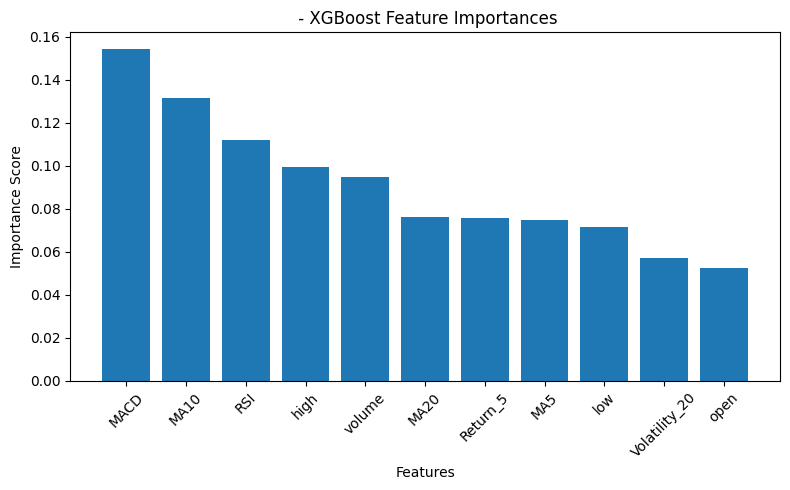


Full Feature Importance Ranking:
          Feature  Importance
0            MA10    0.131414
1            MA20    0.076040
2             MA5    0.074767
3            MACD    0.154330
4             RSI    0.111823
5        Return_5    0.075659
6   Volatility_20    0.057263
7            high    0.099578
8             low    0.071561
9            open    0.052610
10         volume    0.094954
X_selected
           volume    high        RSI     MA10      MACD
0      4144300.0   99.75  46.392985   92.068  3.590061
1      7528400.0  103.75  69.053118   92.911  3.808093
2      5522900.0  104.50  73.221423   94.098  4.349537
3      5065700.0  110.62  78.621570   96.092  5.292952
4      5785000.0  115.56  85.312862   98.630  6.355480
...          ...     ...        ...      ...       ...
6419  46607693.0  205.70  38.107583  200.904 -1.089823
6420  72862557.0  206.00  38.119935  201.522 -1.089237
6421  54672608.0  204.35  43.051410  201.768 -0.979042
6422  60989857.0  204.50  44.345746  201.604

r:\OMOTEC\Stock_price_optimization\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
actual
 [319.23 316.85 318.89 ... 202.67 198.78 199.2 ]
pred
 [309.3068078  310.92997811 313.03838911 ... 195.26173743 196.09700764
 197.76210676]
NaN count per column in merged_data:
volume    0
high      0
RSI       0
MA10      0
MACD      0
close     0
dtype: int64


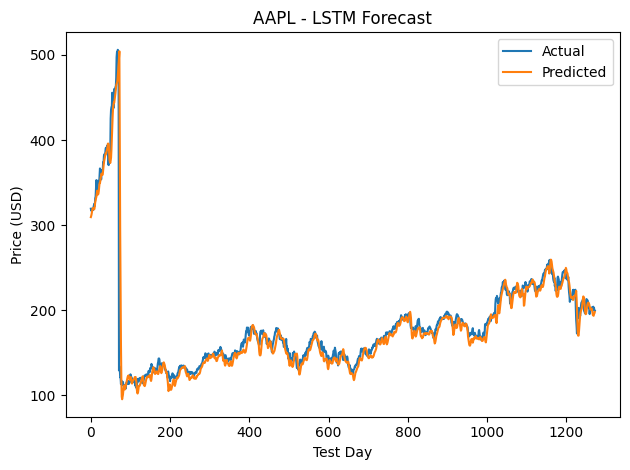


=== Processing: MSFT ===
Loading cached data for MSFT
    open   high    low  close      volume
0  93.25  94.19  92.12  92.37  26630600.0
1  92.75  94.50  91.94  92.56  23174500.0
2  92.94  93.50  91.50  92.00  22258500.0
3  92.31  92.75  90.31  91.75  27119700.0
4  91.81  92.87  90.50  91.56  35083700.0


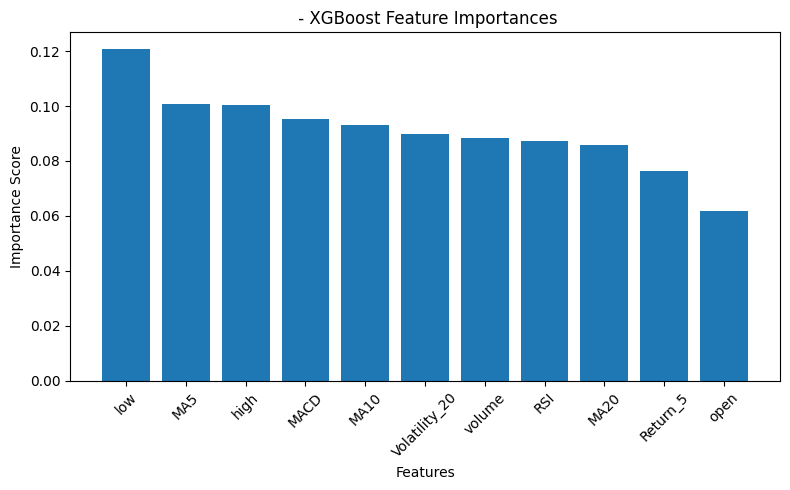


Full Feature Importance Ranking:
          Feature  Importance
0            MA10    0.093007
1            MA20    0.085858
2             MA5    0.100841
3            MACD    0.095294
4             RSI    0.087412
5        Return_5    0.076399
6   Volatility_20    0.089743
7            high    0.100507
8             low    0.120770
9            open    0.061838
10         volume    0.088331
X_selected
          MA10       MACD     high      MA5      low
0      88.268  -0.477291   92.060   90.486   89.500
1      88.673  -0.307880   92.870   90.734   89.560
2      89.261  -0.000929   93.940   91.448   90.870
3      90.242   0.368801   95.250   92.072   92.870
4      91.360   0.758774   97.120   93.072   95.730
...       ...        ...      ...      ...      ...
6419  461.414  13.330785  473.335  465.374  468.780
6420  463.671  13.323618  473.430  467.530  468.620
6421  464.694  13.020185  472.800  469.120  466.960
6422  466.220  12.769686  475.470  470.870  469.655
6423  468.239  12.9264

r:\OMOTEC\Stock_price_optimization\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
actual
 [185.66 183.43 183.51 ... 470.92 472.62 478.87]
pred
 [181.88022161 181.99125095 182.34121311 ... 405.8047332  408.3018016
 410.32506742]
NaN count per column in merged_data:
MA10     0
MACD     0
high     0
MA5      0
low      0
close    0
dtype: int64


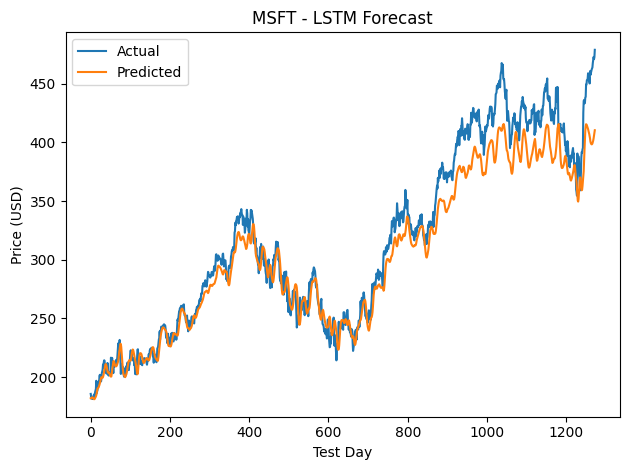


=== Processing: GOOGL ===
Loading cached data for GOOGL
     open    high     low    close      volume
0  100.01  104.06   95.96  100.335  44659000.0
1  101.01  109.08  100.50  108.310  22834300.0
2  110.76  113.48  109.05  109.400  18256100.0
3  111.24  111.60  103.57  104.870  15247300.0
4  104.76  108.00  103.88  106.000   9188600.0


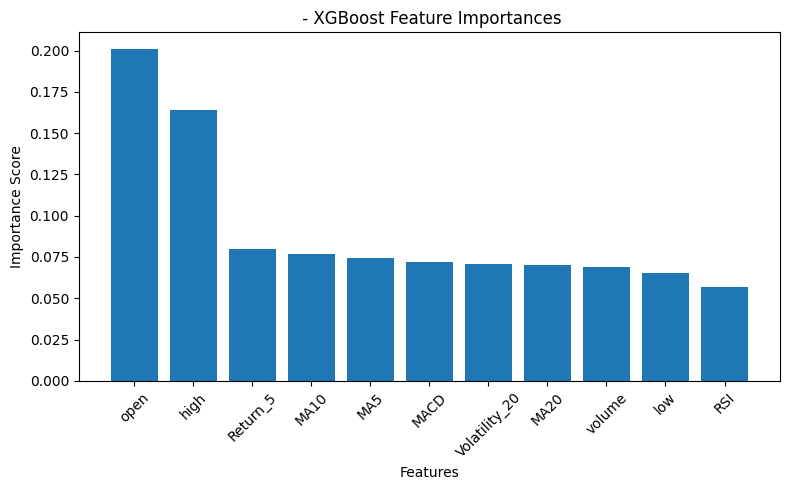


Full Feature Importance Ranking:
          Feature  Importance
0            MA10    0.076843
1            MA20    0.070291
2             MA5    0.074638
3            MACD    0.071733
4             RSI    0.056942
5        Return_5    0.079889
6   Volatility_20    0.070548
7            high    0.163953
8             low    0.065330
9            open    0.200982
10         volume    0.068849
X_selected
           MA5     MA10  Return_5     high    open
0     110.058  105.800  0.113967  115.800  112.34
1     112.490  107.398  0.115447  117.490  114.42
2     114.862  109.333  0.110326  121.600  116.95
3     116.132  110.959  0.056956  120.420  120.20
4     117.408  112.567  0.056964  119.670  117.45
...       ...      ...       ...      ...     ...
5214  169.030  170.248  0.011296  174.500  170.83
5215  170.442  171.010  0.041768  176.470  174.54
5216  172.926  171.580  0.074738  181.105  176.20
5217  174.786  172.079  0.055341  180.370  179.77
5218  176.284  172.463  0.044528  176.720  1

r:\OMOTEC\Stock_price_optimization\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
actual
 [2314.77 2337.35 2351.93 ...  178.6   177.35  175.7 ]
pred
 [2223.45706166 2223.46626503 2217.59572696 ...  168.65171672  171.24238012
  176.26396107]
NaN count per column in merged_data:
MA5         0
MA10        0
Return_5    0
high        0
open        0
close       0
dtype: int64


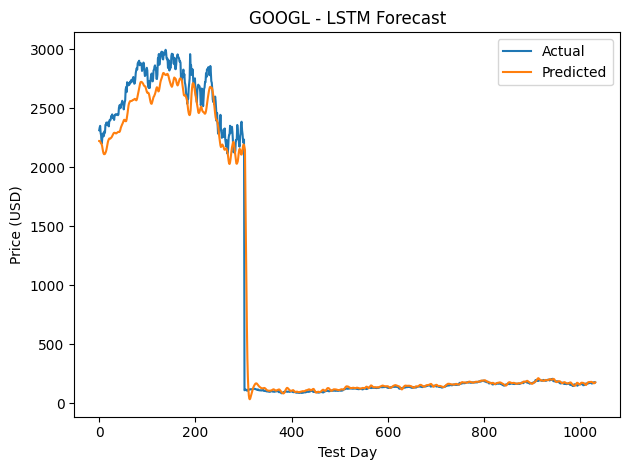


=== Processing: TSLA ===
Loading cached data for TSLA
    open     high    low  close      volume
0  19.00  25.0000  17.54  23.89  18766300.0
1  25.79  30.4192  23.30  23.83  17187100.0
2  25.00  25.9200  20.27  21.96   8218800.0
3  23.00  23.1000  18.71  19.20   5139800.0
4  20.00  20.0000  15.83  16.11   6866900.0


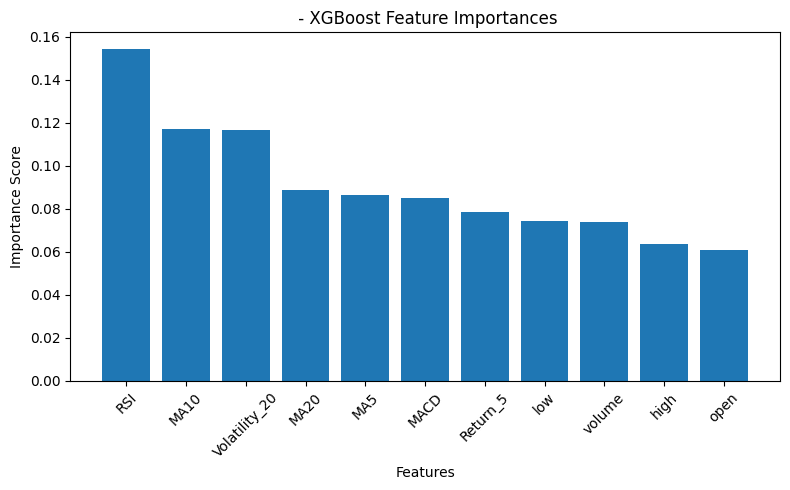


Full Feature Importance Ranking:
          Feature  Importance
0            MA10    0.117063
1            MA20    0.088868
2             MA5    0.086632
3            MACD    0.084992
4             RSI    0.154392
5        Return_5    0.078506
6   Volatility_20    0.116549
7            high    0.063544
8             low    0.074554
9            open    0.061063
10         volume    0.073838
X_selected
           MA5      MA20  Volatility_20     MA10        RSI
0      20.802   19.8715       2.296462   20.659  72.770853
1      20.902   19.7130       2.106009   20.747  68.232662
2      20.772   19.5390       1.879541   20.793  65.945946
3      20.502   19.4380       1.794968   20.723  65.520945
4      20.496   19.5240       1.823936   20.624  65.108696
...       ...       ...            ...      ...        ...
3739  319.770  335.7815      21.095022  336.287  31.133893
3740  312.948  336.2975      20.237709  333.211  38.895884
3741  309.312  336.6830      19.949827  329.531  44.681106
3742

r:\OMOTEC\Stock_price_optimization\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
actual
 [733.63  752.29  703.03  699.21  711.12  714.94  720.2   721.64  736.59
 742.5   815.12  816.73  805.3   776.58  824.46  842.7   891.45  891.83
 901.76  922.19  925.9   864.51  871.27  850.    883.07  859.89  900.09
 927.96  919.69  911.99  908.61  890.    869.74  889.36  891.29  296.07
 288.09  284.82  277.7   275.61  277.16  270.21  274.42  283.7   289.26
 299.68  304.42  292.13  302.61  303.75  303.35  309.07  308.73  300.8
 288.59  275.33  276.01  282.94  287.81  268.21  265.25  242.4   249.44
 240.81  238.13  223.07  222.96  216.5   217.24  221.72  204.99  219.35
 220.19  222.04  207.28  214.44  211.25  222.415 224.64  225.09  228.52
 227.54  227.82  214.98  215.31  207.47  197.08  191.3   177.59  190.72
 195.97  190.95  194.42  186.92  183.17  180.19  167.87  169.91  183.2
 182.86  182.92  180.83  194.7   194.7   194.86  182.45  179.82  174.04
 173.44  179.05  167.82  160.95  156.8   157.67  150.23  149.87  137.8
 137.57  125.35  12

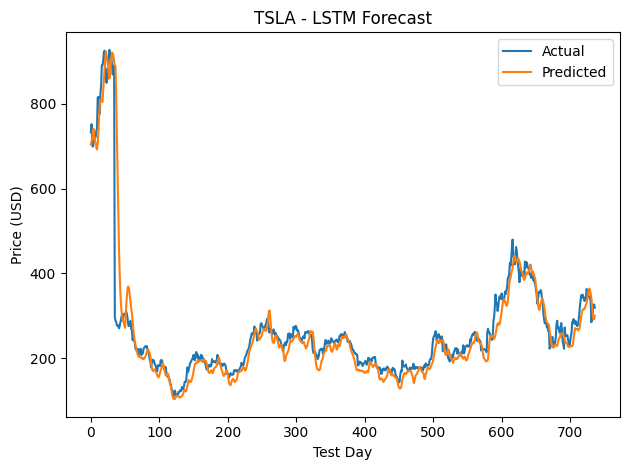


=== Processing: AMZN ===
Loading cached data for AMZN
    open   high    low  close      volume
0  68.06  71.88  66.31  69.13  12824100.0
1  69.75  70.00  65.06  66.44  13243200.0
2  68.19  68.50  65.00  65.81  10772100.0
3  67.19  67.19  61.00  63.06  16759200.0
4  64.75  65.50  62.25  64.94  11091400.0


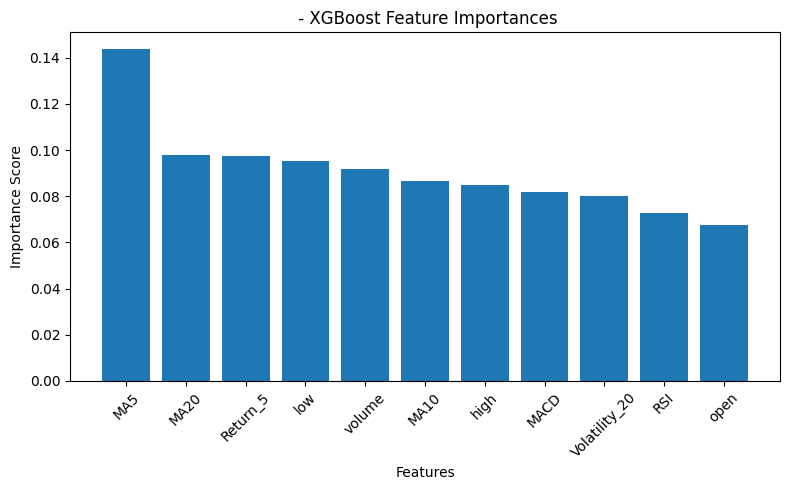


Full Feature Importance Ranking:
          Feature  Importance
0            MA10    0.086749
1            MA20    0.097774
2             MA5    0.143853
3            MACD    0.081647
4             RSI    0.072909
5        Return_5    0.097246
6   Volatility_20    0.080081
7            high    0.084865
8             low    0.095337
9            open    0.067738
10         volume    0.091802
X_selected
           volume     low  Return_5      MA20      MA5
0     18053700.0   90.13  0.160380   75.8010   86.614
1     13465500.0   83.81  0.056646   76.5975   87.526
2     10663600.0   81.97  0.039755   77.5255   88.176
3      9538700.0   85.63  0.020745   78.6880   88.538
4     11151200.0   86.06 -0.070547   79.8630   87.224
...          ...     ...       ...       ...      ...
6419  39832500.0  210.50  0.041754  205.6020  208.214
6420  38102502.0  212.88  0.049988  206.7980  210.280
6421  31303317.0  214.15  0.057848  207.2465  212.660
6422  39325981.0  212.89  0.028809  207.3380  213.854


r:\OMOTEC\Stock_price_optimization\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
actual
 [2497.94 2446.74 2436.88 ...  217.61  213.2   213.24]
pred
 [2322.11109089 2335.9845512  2356.96394646 ...  198.99896672  200.98859409
  204.34720921]
NaN count per column in merged_data:
volume      0
low         0
Return_5    0
MA20        0
MA5         0
close       0
dtype: int64


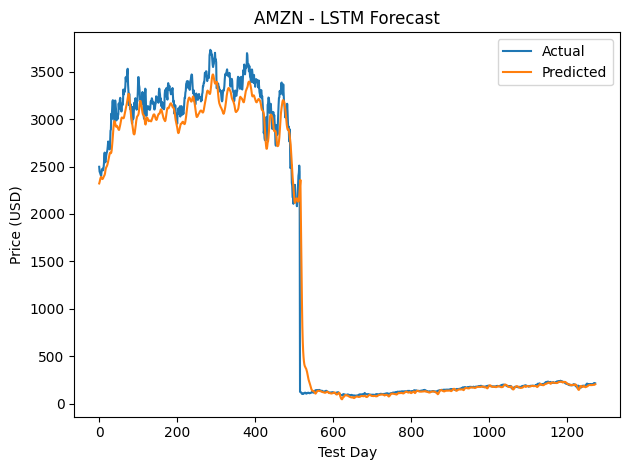

In [14]:
for symbol in symbols:
    print(f"\n=== Processing: {symbol} ===")

    # data, _ = ts.get_daily(symbol=symbol, outputsize='full')
    # data = prepare_data(data)
    data = load_or_fetch_data(symbol, api_key)
    print(data.head())
    data = add_technical_indicators(data)
    X_selected, y_target = select_features(data)


    print("X_selected\n",X_selected)
    print("y_target\n",y_target)

    merged_data = pd.concat([X_selected, y_target], axis=1).dropna().reset_index(drop=True)

    actual, pred = lstm_forecast_multivariate(merged_data, target='close')

    print("actual\n", actual)
    print("pred\n", pred)

    print("NaN count per column in merged_data:")
    print(merged_data.isna().sum())

    # Storing the volatility and cumulative return
    initial_price = actual[0]
    final_price = actual[-1]
    cumulative_return = (final_price - initial_price) / initial_price
    volatility = np.std(np.diff(actual) / actual[:-1])
    stock_stats.append({
        'symbol': symbol,
        'cumulative_return': cumulative_return,
        'volatility': volatility
    })

    rmse = math.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    results[symbol] = {'RMSE': rmse, 'MAE': mae}

    # Plot Results
    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(f"{symbol} - LSTM Forecast")
    plt.xlabel("Test Day")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Calssifying Stocks using ABC Analysis

In [12]:
def classify_stocks_by_return(stock_stats_df):
    # Sort by cumulative return descending
    sorted_df = stock_stats_df.sort_values(by='cumulative_return', ascending=False).reset_index(drop=True)
    n = len(sorted_df)
    a_cutoff = int(0.2 * n)
    b_cutoff = int(0.5 * n)

    categories = ['A' if i < a_cutoff else 'B' if i < b_cutoff else 'C' for i in range(n)]
    sorted_df['ABC'] = categories
    return sorted_df

In [18]:
stock_stats_df = pd.DataFrame(stock_stats)
print("\nStock Statistics DataFrame:")
print(stock_stats_df)
classified_df = classify_stocks_by_return(stock_stats_df)
print("\nClassified Stocks by Return:")
print(classified_df)
abc_map = dict(zip(classified_df['symbol'], classified_df['ABC']))
print("\nABC Classification Map:")
print(abc_map)


Stock Statistics DataFrame:
  symbol  cumulative_return  volatility
0   AAPL          -0.375998    0.028050
1   MSFT           1.579285    0.017014
2  GOOGL          -0.924096    0.035665
3   TSLA          -0.565026    0.046570
4   AMZN          -0.914634    0.034790

Classified Stocks by Return:
  symbol  cumulative_return  volatility ABC
0   MSFT           1.579285    0.017014   A
1   AAPL          -0.375998    0.028050   B
2   TSLA          -0.565026    0.046570   C
3   AMZN          -0.914634    0.034790   C
4  GOOGL          -0.924096    0.035665   C

ABC Classification Map:
{'MSFT': 'A', 'AAPL': 'B', 'TSLA': 'C', 'AMZN': 'C', 'GOOGL': 'C'}


### Printing the Summary Report

In [ ]:
print("\n==== Forecasting Performance Summary ====")
for sym, res in results.items():
    print(f"{sym}: RMSE = {res['RMSE']:.4f}, MAE = {res['MAE']:.4f}")